In [1]:
# import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, colorbar

In [2]:
import numpy as np
import os

# generate the groudtruth data
# y = sum_{k=1}^K a0k conv x0k + b*1 + n
def gen_data_2D_with_time(arg, pattern = False):
    """
    Parameters:
    ----------------
    arg should include the following items {
        theta: the threshold for generating spike train X_0
        x_grid: a length 2 list denoting the grid dimension for X
        n: the dimension of the kernel (we use squared kernel)
        b: the magnitude of the bias term
        T: how many time steps do you want
        noise_level: the magnitude of noise
        a_type: the kernel type we want to apply on X (randn, 2d-gaussian, sinc)
        x_type: which method we want to generate x_0 (bernoulli, bernoulli-gaussian)
        raw_data_handeling: our generated X may have some entry as negative values,
                        however, this will not happen in real image, so we need
                        to take care of those negative entries. (max_0, sigmoid)
        X_0: pattern image
        }
    
    pattern: whether you want to use a pattern image or not, default is no,
             means we want to generate some random image
    """
    # Take the inputs!
    n = arg["n"] # Dimension of t# generate the groudtruth data
# y = sum_{k=1}^K a0k conv x0k + b*1 + n
def gen_data_2D_with_time(arg, pattern = False):
    """
    Parameters:
    ----------------
    arg should include the following items {
        theta: the threshold for generating spike train X_0
        x_grid: a length 2 list denoting the grid dimension for X
        n: the dimension of the kernel (we use squared kernel)
        b: the magnitude of the bias term
        T: how many time steps do you want
        noise_level: the magnitude of noise
        a_type: the kernel type we want to apply on X (randn, 2d-gaussian, sinc)
        x_type: which method we want to generate x_0 (bernoulli, bernoulli-gaussian)
        raw_data_handeling: our generated X may have some entry as negative values,
                        however, this will not happen in real image, so we need
                        to take care of those negative entries. (max_0, sigmoid)
        X_0: pattern image
        }
    
    pattern: whether you want to use a pattern image or not, default is no,
             means we want to generate some random image
    """
    # Take the inputs!
    n = arg["n"] # Dimension of the kernel
    b = arg["b"] # Magnitude of the bias term
    T = arg["T"] # How many time steps to take
    noise_level = arg["noise_level"] # the magnitude of noise
    a_type = arg["a_type"] # Kernel type
    raw_data_handeling = arg["raw_data_handeling"]
    
    if pattern:
        X_0 = arg["X_0"]
    else:
        theta = arg["theta"]
        x_grid = arg["xgrid"]
        x_type = arg["x_type"]
    
    # generate the kernel a_0
    case = a_type.lower()
    if case == "randn": # Random Gaussian
        a_0 = np.random.normal(size = [n, n])
    elif case == "sinc":
        sigma = 0.05
        a_0 = np.sinc((t-0.5)/sigma)
    elif case == "2d-gaussian":
        sigma = 0.5 # could perturb sigma if you want
        # 2D gaussian kernel
        grid_hori = np.linspace(-n / 2, n / 2, n)
        grid_verti = grid_hori.copy()
        mesh_x, mesh_y = np.meshgrid(grid_hori, grid_verti)
        a_0 = 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(mesh_x ** 2 + mesh_y ** 2) / 2 * sigma ** 2)
    else:
        raise ValueError("Wrong type")

    #a_0 = a_0 / np.linalg.norm(a_0, axis = 0)  # Normalize kernel by column
    a_0 = a_0 / np.max(np.linalg.eig(a_0)[0])
    
    if pattern == False:
        # Generate the spike train x_0
        m_0, m_1 = x_grid
        case_x = x_type.lower()
        if case_x == "bernoulli":
            thetas = 0
            X_0 = (np.random.uniform(size = [m_0, m_1]) <= theta).astype(int) # Bernoulli spike train
        elif case_x == 'bernoulli-gaussian':
            # Gaussian-Bernoulli spike train
            thetas = np.zeros((T+1, int(theta//0.01), 2))
#             X_0 = np.random.normal(size = [m_0, m_1]) * (np.random.uniform(size = [m_0, m_1]) <= theta)
            mask = np.arange(m_0*m_1) * 0.01
            np.random.shuffle(mask)
            mask = mask.reshape(m_0, m_1)
#             X_0 = np.random.normal(size = [m_0, m_1]) * (mask < theta)
            X_0 = np.ones((m_0, m_1)) * (mask < theta)
            thetas[-1] = np.argwhere(np.absolute(X_0)>0)
        else:
            raise ValueError("Wrong type")
        # Now handle negative entries
        if case_x != "bernoulli":
            case_handle = raw_data_handeling.lower()
            if case_handle == "max_0":
                X_0 = np.maximum(X_0, 0)
            elif case_handle == "sigmoid":
                indices = (X_0 < 0)
                X_0[indices] = 1 / (1 + np.exp(-X_0[indices]))
                
    else:# If we want to use some image with some patterns on it
        m_0, m_1 = X_0.shape
    
    # Now we have X_0 either from random sampling or from pattern image, we 
    # sample the time steps
    indexes = np.where(X_0 != 0) # Nonzero X_0 entries
    # Since our aim should be that by passing through all the time steps,
    # All point should have the chance to reveal itself, so we need to choose 
    # a suitable z (number of shining points at a time step),
    # I see this as a complexed version of the Coupon collecting problem, although not the same
    # we could use the solution to that problem as a guideline.
    X_with_time = np.zeros([m_0, m_1, T]) # Samples we take at each time step
    y_with_time = np.zeros([m_0, m_1, T]) # The blurred y we want to return, where y[:,:,t] means
                                          # y at time step t
    # We first calculate a lower bound for z using the idea of Coupon collecting problem
    def solving_ccp(total_entries, T): # Giving a lower bound of z
        # total entries denote number of non-zero entries in the input
        z = 1 # initialize z
        gamma = 0.577216 # Euler–Mascheroni constant
        ratio = total_entries // z
        while ratio * np.log(ratio) + gamma * ratio + 0.5 > T:
            z += 1
            ratio = total_entries // z
        
        return z
    
    total_entries = np.sum(X_0 != 0)
    # This lower bound is just for this test case, could set it lower if we want more challenge
    z_lower_bound = solving_ccp(total_entries, T)
    # Now in every time step, we pick a z value between lower bound of z and some multiplication of z
    multi_factor = 1.2 # Could change if you want
    z_upperbound = int(z_lower_bound * multi_factor)
    
    for t in range(T):
        z = np.random.randint(z_lower_bound, z_upperbound + 1)
        # Take random samples from indexes
        random_samples = np.random.randint(0, total_entries, z)
        index_to_take = [indexes[i][random_samples] for i in range(len(indexes))]
        current_X = np.zeros([m_0, m_1])
        current_X[tuple(index_to_take)] = X_0[tuple(index_to_take)]
        
        for i in range(z):
            thetas[t][i] = index_to_take[0][i], index_to_take[1][i]
        
        X_with_time[:,:,t] = current_X
        
        # generate the data y = a_0 conv b_0 + bias + noise
        ##### Circular convolution alert
        y_0 = cconv(a_0, current_X, [m_0, m_1]) + b * np.ones([m_0,m_1])
        current_y = y_0 + np.random.normal(size = [m_0, m_1]) * noise_level
        y_with_time[:,:,t] = current_y
    
    # We also return a blurred image of X_0 without sampling
    y_total = cconv(a_0, X_0, [m_0, m_1]) + b * np.ones([m_0,m_1])
    y_total = y_total + np.random.normal(size = [m_0, m_1]) * noise_level
        
    return [X_0, X_with_time, y_with_time, y_total, thetas]


def cconv(mat1, mat2, output_shape):
    # Since there's a lot of functions use circular function
    # and python doesn't have a function for that
    # Dependency of gen_data
    
    return np.real((np.fft.ifft2(np.fft.fft2(mat1, s = output_shape) \
                        * np.fft.fft2(mat2, s = output_shape))))


def sample(arg, batch_size, image_size, n_sources, dim):
    arg = {"n": 2,
       "b": 0.3,
       "T": 10,
       "noise_level": 0.08,
       "a_type": "2d-gaussian",
       "raw_data_handeling": "max_0"}
    arg["theta"] = 0.05
    arg["xgrid"] = [64, 64]
    arg["x_type"] = 'bernoulli-gaussian'
    

    images = np.zeros((batch_size, image_size, image_size))
    thetas = np.zeros((batch_size, n_sources, dim))
    weights = np.zeros((batch_size, n_sources))
    masks = np.ones((batch_size, image_size*image_size))
        
    for b_idx in range(batch_size):
        [X_0, X_with_time, y_with_time, y_total, X_thetas] = gen_data_2D_with_time(arg, pattern = False)
        masks[b_idx, :] = 1 - X_with_time[:,:,0].reshape(1, image_size * image_size)
        images[b_idx,:,:] = y_with_time[:,:,0]
        thetas[b_idx,:,:] = X_thetas[0]
        for i in range(len(X_thetas[0])):
            
            weights[b_idx][i] = np.absolute(X_0[int(X_thetas[0][i][0])][int(X_thetas[0][i][1])])
        
#     plotting_results(X_0, y_with_time, X_with_time, plot_x = False)

    return images, thetas, weights, masks

In [3]:
arg = {"n": 2,
       "b": 0.3,
       "T": 10,
       "noise_level": 0.08,
       "a_type": "randn",
       "raw_data_handeling": "max_0"}
arg["theta"] = 0.05
arg["xgrid"] = [64, 64]
arg["x_type"] = 'bernoulli-gaussian'

In [4]:
images, thetas, weights, masks = sample(arg, 2, 64, 5, 2)

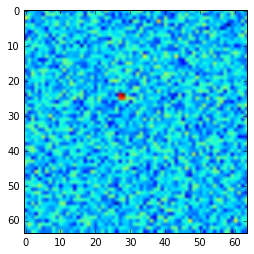

[[ 24.  27.]
 [ 24.  27.]
 [  0.   0.]
 [  0.   0.]
 [  0.   0.]]
[ 1.  1.  0.  0.  0.]


In [5]:
plt.imshow(images[0])
plt.show()
print(thetas[0])
print(weights[0])

In [7]:
import torch

In [8]:
images= torch.autograd.Variable(torch.Tensor(images))

In [9]:
import nets
net = torch.load("net_sim")

In [ ]:
from torch.autograd import Variable
net.eval()
(o_theta, o_w) = net(images)

In [3]:
torch.__version__

'1.3.1'